In [1]:
import torch
from torch import nn
from torchvision import transforms

from torchinfo import summary

from going_modular import data_setup, engine

In [2]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Get data

Want to get pizza, steak, sushi images.

So we can run experiments building FoodVision Mini and see which model performs best

In [3]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it..
if image_path.is_dir():
    print(f"directory exist")
else:
    print(f"Directory, creating one...")
    image_path.mkdir(presents=True, exist_ok=True)
    
# # Download pizza, steak, sushi
# with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
#     request = requests.get("")
#     f.write(request.content)
    
# # Unzip, pizza, steak, sushi data
# with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
#     print("Unzipping file.....")
#     zip_ref.extractall(image_path)

directory exist


## 2. Create Dataset and DatLoaders

### 2.1 Create DataLoader with manual trasnforms

In [4]:
# setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [5]:
# Setup ImageNet norma
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create trasnform pipline manually 
from torchvision import transforms
manual_transforms = transforms.Compose([
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        normalize
])

print(f"Nanully created transforms: {manual_transforms}")

# Create DataLoader
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir, 
                                                                               transform=manual_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

Nanully created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x1fc88ac8d60>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Create DataLoader using automatically created trasnforms

In [6]:
# Setup dirs
train_dir = image_path/ "train"
test_dir = image_path / "test"

# setup pretrained weights 
import torchvision 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DAFAULT" = best available

# Get trasnforms from weights 
automatic_transforms = weights.transforms()
print(f"Automatic transforms: {automatic_transforms}")

# Create dataloaders
from going_modular import data_setup
train_dataloader, test_dataloader , class_names = data_setup.create_dataloaders(train_dir=train_dir, 
                                                                                test_dir=test_dir,
                                                                                transform=automatic_transforms,
                                                                                batch_size=32)
train_dataloader, test_dataloader, class_names

Automatic transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x1fc88ae6430>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting pretrained model, freeze the base layer and change the classifier head

In [7]:
# model = torchvision.models.efficientnet_b0(pretraied=True).to(device) # OLD

# setup the model with the pretraind weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT = best available 

model = torchvision.models.efficientnet_b0(weights=weights).to(device)
# model

In [8]:
# Freeze all base layers
for param in model.features.parameters():
    param.requires_grad = False

In [9]:
from torch import nn

model.classifier = nn.Sequential(
                                  nn.Dropout(p=0.2, inplace=True),
                                  nn.Linear(in_features=1280, out_features=len(class_names))
).to(device)

In [10]:
from torchinfo import summary

summary(model=model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train single model and track results

In [11]:
# Loss function and optimzizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [12]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer

In [13]:
from typing import Dict, List, Tuple
from tqdm.auto import tqdm

from going_modular.engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
    # Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
  
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)
      
        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        
        ### New: Experiment tracking ###
        # See summaryWriter documentation
        writer.add_scalars(main_tag="Loss",
                           tag_scalar_dict={"train_loss":train_loss,
                                            "test_loss":test_loss},
                           global_step=epoch)
        
        writer.add_scalars(main_tag="Accuarcy", 
                           tag_scalar_dict={"train_acc":train_acc,
                                            "test_acc": test_acc},
                           global_step=epoch)
        
        writer.add_graph(model=model,
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
        
        # Close the writer
        writer.close()
        ### End new ###
        
    # Return the filled results at the end of the epochs
    return results

In [14]:
# Train model
# Note: Not using engine.train(), since we updated the train() function above

results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1071 | train_acc: 0.3516 | test_loss: 0.8941 | test_acc: 0.7547
Epoch: 2 | train_loss: 0.8710 | train_acc: 0.7188 | test_loss: 0.8166 | test_acc: 0.7547
Epoch: 3 | train_loss: 0.7652 | train_acc: 0.7266 | test_loss: 0.7334 | test_acc: 0.8665
Epoch: 4 | train_loss: 0.7133 | train_acc: 0.7656 | test_loss: 0.6567 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.6173 | train_acc: 0.8086 | test_loss: 0.5708 | test_acc: 0.8864


## 5. View our model's results with TensorBord

In [15]:
%load_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 2916), started 1 day, 21:03:43 ago. (Use '!kill 2916' to kill it.)

## 6. Create a function to prepare a `SummaryWriter()` instance

By default our `SummaryWriter()` class saves to `log_dir`.

How about if we wanted to save diffrent experiments to diffrent folders ?

In essence, one experiment = one folder.

For example, we'd like to track:
* Experiment data/timestamp
* Experiment name
* Model name
* Extra - is there anything else that should be tracked ?

Let's create a function to create a `SummaryWriter()` 

`runs/YYYY-MM-DD/experiment_name/model_name/extra`

In [16]:
from torch.utils.tensorboard import SummaryWriter

def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str = None):
    """Create a torch.utils.tensorboard.writer.SummaryWriter() instance tracking to specific directory."""
    from datetime import datetime
    import os
    
    # Get timestamp of current date reverse order
    timestamp = datetime.now().strftime("%Y-%m-%d")
    
    if extra:
        # Create log direcoty path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    print(f"[INFO]: Create SummaryWriter saving to {log_dir}")
    return SummaryWriter(log_dir=log_dir)

In [17]:
example_writer = create_writer(experiment_name="data_10_parcent",
                               model_name="effnetb0",
                               extra="5_epochs")
example_writer

[INFO]: Create SummaryWriter saving to runs\2023-03-10\data_10_parcent\effnetb0\5_epochs


### 6.1 Update the train() function include a `writer` parameter

In [18]:
# Update train() to use create_writer()...

from typing import Dict, List, Tuple
from tqdm.auto import tqdm

from going_modular.engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List[float]]:
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
  
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)
      
        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        
        ### New: Experiment tracking ###
        
        if writer:
            # See summaryWriter documentation
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={"train_loss":train_loss,
                                                "test_loss":test_loss},
                               global_step=epoch)

            writer.add_scalars(main_tag="Accuarcy", 
                               tag_scalar_dict={"train_acc":train_acc,
                                                "test_acc": test_acc},
                               global_step=epoch)

            writer.add_graph(model=model,
                             input_to_model=torch.randn(32, 3, 224, 224).to(device))

            # Close the writer
            writer.close()
            
        else:
            pass
            
        ### End new ###
        
    # Return the filled results at the end of the epochs
    return results

## 7. Setting up a series of modelling experiments

* Setup 2x modelling experiments with effnetb0, pizza, stack, data train one model for 5 epochs and another model for 10 epochs

### 7.1 What kind of experiment should you run ?

So what should you test ?
* Change the number of epochs
* change the number of hidden layers/units
* Change the amount of data (right now we are using 10% of the food101 dataset to pizza, stack, shushi)
* Change the learning rate
* Try diffrent kinds of data augmentation 
* Choose a different model architecture


## 7.2 What experiment are we going to run ?

We're going to turn three dials:

    1. Model size - EffnetB0 vs EffnerB2 (in terms of parameters)
    2. Dataset size - 10% of pizza, steak, sushi images vs 20% (generally more data = better results)
    3. Dataset time - 5 epochs vs 10 epochs (generally longer training time = better tesults, up to a point)
    
To begin , keeping things relatively small so that our experiment run quickly.

### 7.3 Download different datasets

We want datasets:
 
 1. Pizza,steak,sushi 10%
    
 1. Pizza,steak,sushi 20%

### 7.4 Transforms Datasets and create DataLoaders

1. Resize the image to (224, 224)
2. Make sure image tensor values are between [0,1]
3. Normalize the image so they have the same data distribution as ImageNet

In [19]:
from pathlib import Path
data_path = Path("data/")

# Setup training directory paths
train_dir_10_percent =  data_path/"pizza_steak_sushi"/"train"
train_dir_20_percent = data_path/"pizza_steak_sushi_20_percent"/"train"

# Setup test directory
test_dir = data_path/"pizza_steak_sushi"/"test"

train_dir_10_percent, train_dir_20_percent, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [20]:
# Create a transforms 

from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Compose transforms into a pipline
simple_transforms = transforms.Compose([
                                         transforms.Resize((224,224)),
                                         transforms.ToTensor(), 
                                         normalize
])

In [21]:
BATACH_SIZE = 32

from going_modular import data_setup

# Create 10% training and test dataloaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transforms,
                                                                                          batch_size=BATACH_SIZE)

train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transforms,
                                                                                          batch_size=BATACH_SIZE)

print(f"Number of batch of size {BATACH_SIZE} in 10% train data: {len(train_dataloader_10_percent)}")
print(f"Number of batch of size {BATACH_SIZE} in 20% train data: {len(train_dataloader_20_percent)}")
print(f"Number of batch of size {BATACH_SIZE} in 10% test data: {len(test_dataloader)}")
print(f"Class names: {class_names}")

Number of batch of size 32 in 10% train data: 8
Number of batch of size 32 in 20% train data: 15
Number of batch of size 32 in 10% test data: 3
Class names: ['pizza', 'steak', 'sushi']


### 7.5 Create feature extractor models

We want two functions:

1. Crate a `torchvision.models.efficnetnet_b0()` feature extractor with a frozen backbone/base layers and a custom classifer head(EffNetB0).

2. Crate a `torchvision.models.efficnetnet_b2()` feature extractor with a frozen backbone/base layers and a custom classifer head(EffnetB2).

In [22]:
import torchvision

# Create an EffNetB2
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" = best available
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

effnetb2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [23]:
from torchinfo import summary

summary(model=effnetb2,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [24]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

# Create an EffNetB0 featurs extractor
def create_effnetb0():
    # Get weights and setup model
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)
    
    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False
        
    # change classifier head
    model.classifier = nn.Sequential(
                                      nn.Dropout(p=0.3, inplace=True),
                                      nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)
    
    # Give the model name
    model.name = "effnetb0"
    print(f"[INFO] Create new {model.name} model......")
    
    return model



# Create an EffNetB2 featurs extractor
def create_effnetb2():
    # Get weights and setup model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    
    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False
        
    # change classifier head
    model.classifier = nn.Sequential(
                                      nn.Dropout(p=0.3, inplace=True),
                                      nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)
    
    # Give the model name
    model.name = "effnetb2"
    print(f"[INFO] Create new {model.name} model......")
    
    return model

In [25]:
effnetb2.classifier 

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [26]:
created_model_test_effnetb2 = create_effnetb2()
created_model_test_effnetb0 = create_effnetb0()

[INFO] Create new effnetb2 model......
[INFO] Create new effnetb0 model......


In [27]:
from torchinfo import summary

summary(model=created_model_test_effnetb2,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [28]:
from torchinfo import summary

summary(model=created_model_test_effnetb0,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### 7.6 Create experiment and setup training code

In [31]:
# Create epoch list 
num_epochs = [5, 10]

# Create model list
models = ["effnetb0", "effnetb2"]

# Create a DataLoaders dictionry
train_dataloader = {"data_10_percent" : train_dataloader_10_percent,
                    "data_20_percent" : train_dataloader_20_percent}

In [32]:
%%time

from going_modular.utils import save_model

# Keep track of experiment numbers
experiment_number = 0

# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloader.items():
    # Loop throught epochs
    for epochs in num_epochs:
        # Loop throught each model name and create a new model instance
        for model_name in models:
            
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")
            
            
            # Select and create the model
            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_effnetb2()
                
            #  Loss fn and optimizer
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
            
            # Train target model with target dataloader and track expriments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # Save model to file 
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            
            print("_"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Create new effnetb0 model......
[INFO]: Create SummaryWriter saving to runs\2023-03-10\data_10_percent\effnetb0\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0046 | train_acc: 0.5742 | test_loss: 0.9584 | test_acc: 0.5492
Epoch: 2 | train_loss: 0.8980 | train_acc: 0.5508 | test_loss: 0.8409 | test_acc: 0.5994
Epoch: 3 | train_loss: 0.7435 | train_acc: 0.8164 | test_loss: 0.6509 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7063 | train_acc: 0.7500 | test_loss: 0.5891 | test_acc: 0.9271
Epoch: 5 | train_loss: 0.5975 | train_acc: 0.8867 | test_loss: 0.6106 | test_acc: 0.8456
[INFO] Saving model to: models\07_effnetb0_data_10_percent_5_epochs.pth
__________________________________________________

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Create new effnetb2 model......
[INFO]: Create SummaryWriter saving to runs\2023-03-10\data_10_percent\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0681 | train_acc: 0.4531 | test_loss: 0.9315 | test_acc: 0.6525
Epoch: 2 | train_loss: 0.8863 | train_acc: 0.7070 | test_loss: 0.8337 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7656 | train_acc: 0.8555 | test_loss: 0.7259 | test_acc: 0.8769
Epoch: 4 | train_loss: 0.6685 | train_acc: 0.8359 | test_loss: 0.6724 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6120 | train_acc: 0.8125 | test_loss: 0.6541 | test_acc: 0.8561
[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
__________________________________________________

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Create new effnetb0 model......
[INFO]: Create SummaryWriter saving to runs\2023-03-10\data_10_percent\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0481 | train_acc: 0.3984 | test_loss: 0.8948 | test_acc: 0.8030
Epoch: 2 | train_loss: 0.8666 | train_acc: 0.6211 | test_loss: 0.7142 | test_acc: 0.8447
Epoch: 3 | train_loss: 0.7252 | train_acc: 0.8125 | test_loss: 0.7071 | test_acc: 0.8352
Epoch: 4 | train_loss: 0.7262 | train_acc: 0.7188 | test_loss: 0.6971 | test_acc: 0.8352
Epoch: 5 | train_loss: 0.6345 | train_acc: 0.7266 | test_loss: 0.6403 | test_acc: 0.8561
Epoch: 6 | train_loss: 0.6071 | train_acc: 0.8164 | test_loss: 0.5991 | test_acc: 0.8561
Epoch: 7 | train_loss: 0.5384 | train_acc: 0.9375 | test_loss: 0.5110 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.4947 | train_acc: 0.8984 | test_loss: 0.4750 | test_acc: 0.8864
Epoch: 9 | train_loss: 0.5452 | train_acc: 0.7695 | test_loss: 0.4586 | test_acc: 0.8968
Epoch: 10 | train_loss: 0.5096 | train_acc: 0.7812 | test_loss: 0.5243 | test_acc: 0.8873
[INFO] Saving model to: models\07_effnetb0_data_10_percent_10_epochs.pth
____________________________________

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0997 | train_acc: 0.3945 | test_loss: 0.9626 | test_acc: 0.6922
Epoch: 2 | train_loss: 0.8771 | train_acc: 0.8242 | test_loss: 0.8443 | test_acc: 0.8655
Epoch: 3 | train_loss: 0.8143 | train_acc: 0.7227 | test_loss: 0.8041 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.7453 | train_acc: 0.7617 | test_loss: 0.7627 | test_acc: 0.8561
Epoch: 5 | train_loss: 0.6128 | train_acc: 0.9180 | test_loss: 0.6934 | test_acc: 0.8665
Epoch: 6 | train_loss: 0.6244 | train_acc: 0.7773 | test_loss: 0.6587 | test_acc: 0.8665
Epoch: 7 | train_loss: 0.5333 | train_acc: 0.9492 | test_loss: 0.6212 | test_acc: 0.8873
Epoch: 8 | train_loss: 0.5745 | train_acc: 0.8203 | test_loss: 0.5686 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.5121 | train_acc: 0.8164 | test_loss: 0.5528 | test_acc: 0.9176
Epoch: 10 | train_loss: 0.5380 | train_acc: 0.8125 | test_loss: 0.5698 | test_acc: 0.8977
[INFO] Saving model to: models\07_effnetb2_data_10_percent_10_epochs.pth
____________________________________

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9358 | train_acc: 0.6167 | test_loss: 0.7405 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.6789 | train_acc: 0.8229 | test_loss: 0.5763 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.6007 | train_acc: 0.8208 | test_loss: 0.4807 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5103 | train_acc: 0.8417 | test_loss: 0.4557 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.4279 | train_acc: 0.8938 | test_loss: 0.3654 | test_acc: 0.9280
[INFO] Saving model to: models\07_effnetb0_data_20_percent_5_epochs.pth
__________________________________________________

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Create new effnetb2 model......
[INFO]: Create SummaryWriter saving to runs\2023-03-10\data_20_percent\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9801 | train_acc: 0.5604 | test_loss: 0.7754 | test_acc: 0.8466
Epoch: 2 | train_loss: 0.7334 | train_acc: 0.8292 | test_loss: 0.6660 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.5911 | train_acc: 0.8646 | test_loss: 0.6060 | test_acc: 0.8059
Epoch: 4 | train_loss: 0.5104 | train_acc: 0.8833 | test_loss: 0.5240 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4500 | train_acc: 0.8917 | test_loss: 0.4913 | test_acc: 0.8977
[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
__________________________________________________

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Create new effnetb0 model......
[INFO]: Create SummaryWriter saving to runs\2023-03-10\data_20_percent\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9407 | train_acc: 0.6042 | test_loss: 0.6993 | test_acc: 0.9072
Epoch: 2 | train_loss: 0.7115 | train_acc: 0.7896 | test_loss: 0.5471 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.5811 | train_acc: 0.8354 | test_loss: 0.5089 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5277 | train_acc: 0.8521 | test_loss: 0.4203 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4493 | train_acc: 0.9062 | test_loss: 0.4025 | test_acc: 0.9081
Epoch: 6 | train_loss: 0.4513 | train_acc: 0.8354 | test_loss: 0.3550 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.3626 | train_acc: 0.9042 | test_loss: 0.3460 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3245 | train_acc: 0.9208 | test_loss: 0.3176 | test_acc: 0.9489
Epoch: 9 | train_loss: 0.3332 | train_acc: 0.9229 | test_loss: 0.3030 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.3453 | train_acc: 0.9062 | test_loss: 0.2823 | test_acc: 0.9280
[INFO] Saving model to: models\07_effnetb0_data_20_percent_10_epochs.pth
____________________________________

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9847 | train_acc: 0.5292 | test_loss: 0.8164 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7378 | train_acc: 0.8396 | test_loss: 0.6818 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.5974 | train_acc: 0.8771 | test_loss: 0.5957 | test_acc: 0.8362
Epoch: 4 | train_loss: 0.4903 | train_acc: 0.8583 | test_loss: 0.5052 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4450 | train_acc: 0.8979 | test_loss: 0.5004 | test_acc: 0.8362
Epoch: 6 | train_loss: 0.4289 | train_acc: 0.8688 | test_loss: 0.4401 | test_acc: 0.8968
Epoch: 7 | train_loss: 0.4100 | train_acc: 0.8792 | test_loss: 0.4484 | test_acc: 0.8977
Epoch: 8 | train_loss: 0.4003 | train_acc: 0.8562 | test_loss: 0.4453 | test_acc: 0.8769
Epoch: 9 | train_loss: 0.3087 | train_acc: 0.9417 | test_loss: 0.3969 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.3703 | train_acc: 0.8917 | test_loss: 0.4135 | test_acc: 0.8977
[INFO] Saving model to: models\07_effnetb2_data_20_percent_10_epochs.pth
____________________________________

## 8. View experiments in TesorBoard

We've experiment , experiment, experiment!

Now let's visualize, visualize, visualize!

In [33]:
%load_ext tensorboard
%tensorboard --logdir_ runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


The Best performing model was: 
* Model: effnetb0
* Dataset: pizza,steak, sushi 20%
* Epochs: 10

## 9. Load in the best model and make prediction with it

This is our best model filepath: `models\07_effnetb0_data_20_percent_10_epochs.pth`

In [39]:
# Setup best model filepath
best_model_path = "models/07_effnetb0_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load in the saved state_dict())
best_model = create_effnetb0()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Create new effnetb0 model......


<All keys matched successfully>

In [40]:
# Check the model file size
from pathlib import Path

# Get the model size then convert it to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 15 MB


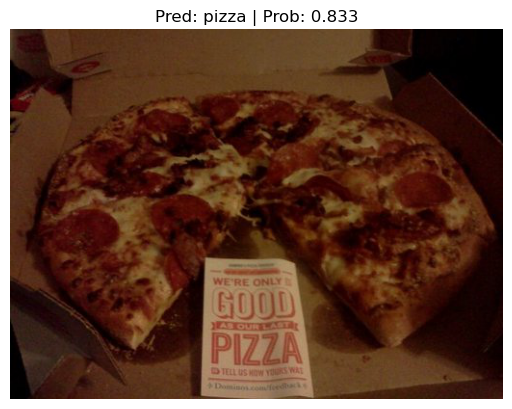

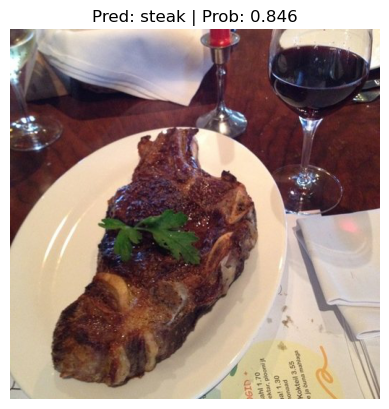

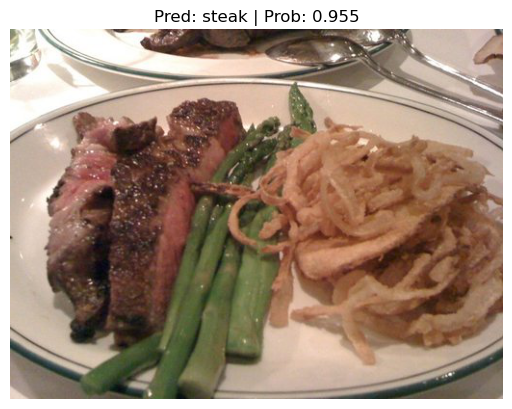

In [95]:
# Import function to make prediction on image and plot them
from going_modular.predictions import pred_and_plot_image

# Get random list of 3 images path names from test datasets
import random 
num_images_to_plot = 3
test_images_path_list = list((data_path/"pizza_steak_sushi_20_percent"/"test").glob("*/*.jpg"))
test_images_path_list
test_image_sample = random.sample(test_images_path_list, k=num_images_to_plot)

for image_path in test_image_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224,224))

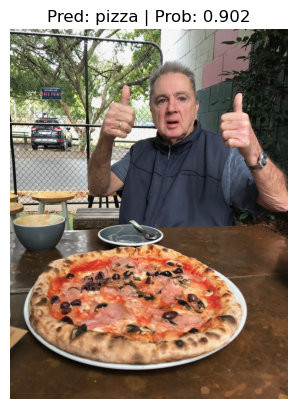

In [100]:
### 9.1 Predict on our custom image
pred_and_plot_image(model=best_model,
                    image_path=data_path/"04-pizza-dad.jpeg",
                    class_names=class_names)